### Project Intro

Project Explanaiton here

## 1. Setting

In [ ]:
# Installation 

!pip install kaggle
!pip install pyspark
!pip install feedparser
!pip install torch
!pip install sentence-transformers
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=3f9559596f5a1e8fd7b6f27d7a8b4fb2c7bfad5f3dde4f884bac23e347e64e66
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=3613da2629b420d2e2483bb8851108800626bd00d167eacf639015671f74d87e
  Stored in

In [ ]:
# libraries
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import * 

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# start sparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()

## 2. Data Wrangling


### 1) Arxiv Data - ahreum


#### a. Import Data

**Arxiv Data**
* id: ArXiv ID (can be used to access the paper, see below)
* submitter: Who submitted the paper
* authors: Authors of the paper
* title: Title of the paper
* comments: Additional info, such as number of pages and figures
* journal-ref: Information about the journal the paper was published in
* doi: [https://www.doi.org](Digital Object Identifier)
* abstract: The abstract of the paper
* categories: Categories / tags in the ArXiv system
* versions: A version history



In [ ]:
!kaggle datasets download -d Cornell-University/arxiv
!unzip /content/arxiv.zip

 99% 1.12G/1.14G [00:08<00:00, 90.5MB/s]
100% 1.14G/1.14G [00:08<00:00, 147MB/s] 
Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [ ]:
arxiv_df = spark.read.json("arxiv-metadata-oai-snapshot.json", multiLine = False, primitivesAsString = True)

In [ ]:
arxiv_df.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|            abstract|             authors|      authors_parsed|       categories|            comments|                 doi|       id|         journal-ref|             license|           report-no|         submitter|               title|update_date|            versions|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|  A fully differe...|C. Bal\'azs, E. L...|[[Balázs, C., ], ...|           hep-ph|37 pages, 15 figu...|10.1103/PhysRevD....|0704.0001|Phys.Rev.D76:0130...|                null|    ANL-HEP

#### b. Authors Analysis

- authors article count (counted by all authors based, merged by first author)
- collaboration T/F

In [ ]:
arxiv_df = arxiv_df.withColumn('first_author', regexp_replace(concat_ws(" ", element_at("authors_parsed", 1)), ",", ""))
arxiv_df = arxiv_df.withColumn("first_author", trim('first_author'))


In [ ]:
author_flattened_ver = arxiv_df.selectExpr("*", "explode(authors_parsed) as authors_flat")
count_df = author_flattened_ver.withColumn('authors_join', regexp_replace(concat_ws(" ", "authors_flat"), ",", ""))
count_df = count_df.withColumn("authors_join", trim(count_df.authors_join))
count_df = count_df.groupBy("authors_join").agg(count('*').alias('article_counts_1st'))
count_df = count_df.orderBy('article_counts_1st', ascending= False)
count_df.show()

+-------------------+------------------+
|       authors_join|article_counts_1st|
+-------------------+------------------+
|           Zhang Y.|              2196|
|            Wang Y.|              1540|
|            Wang J.|              1443|
|              Li Y.|              1366|
|           Liu Yang|              1265|
|           Zhang L.|              1249|
|           Wang Wei|              1206|
|             Liu X.|              1196|
|             Gao Y.|              1185|
|  CMS Collaboration|              1175|
|  Taniguchi Takashi|              1171|
|            Wang Z.|              1147|
|     Watanabe Kenji|              1132|
|ATLAS Collaboration|              1076|
|            Yang Z.|              1042|
|             Sun L.|              1017|
|          Zhang Lei|               987|
|              Xu Z.|               945|
|          Zhang Wei|               942|
|        Krokovny P.|               941|
+-------------------+------------------+
only showing top

In [ ]:
count_df.filter(col('authors_join') == 'Zhang Y.').select('article_counts_1st').show()

+------------------+
|article_counts_1st|
+------------------+
|              2196|
+------------------+



In [ ]:
arxiv_df.filter(col('1st_author')=='Zhang Y.').show()

AnalysisException: ignored

In [ ]:
arxiv_df = arxiv_df.join(count_df, arxiv_df.first_author == count_df.authors_join, "left")
arxiv_df.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------+
|            abstract|             authors|      authors_parsed|          categories|            comments|                 doi|        id|         journal-ref|             license|report-no|           submitter|               title|update_date|            versions|        first_author|        authors_join|article_counts_1st|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------+
|  We study a clas.

In [ ]:
arxiv_df = arxiv_df.withColumn('collab_tf', when(lower(col('authors')).contains('collaboration'), 1).otherwise(0))

In [ ]:
arxiv_df.groupBy('collab_tf').agg(count('*').alias('count')).show()

+---------+-------+
|collab_tf|  count|
+---------+-------+
|        1|  24894|
|        0|2213986|
+---------+-------+



#### c. Category Name Mapping

**category name mapping** 

- parsing from arxiv official taxonomy web page "https://arxiv.org/category_taxonomy" : 
**currently parsing is blocked. Trying to use another way.**


In [ ]:
arxiv_df.withColumn('categories_parsed', concat_ws(" ", "categories")).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------+---------+--------------------+
|            abstract|             authors|      authors_parsed|          categories|            comments|                 doi|              id|         journal-ref|             license|          report-no|           submitter|               title|update_date|            versions|        first_author|        authors_join|article_counts_1st|collab_tf|   categories_parsed|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+-------------------+--------------------+--------------------+----

In [ ]:
cat_map_dict = {}
cat_map_dict['cs'] = 'Computer Science'
cat_map_dict['econ'] = 'Economics'
cat_map_dict['eess'] = 'Electrical Engineering and Systems Science'
cat_map_dict['math'] =  'Mathematics'
cat_map_dict['astro-ph'] = 'Astrophysics'
cat_map_dict['cond-mat'] = 'Condensed Matter'
cat_map_dict['gr-qc'] = 'General Relativity and Quantum Cosmology'
cat_map_dict['hep-ex'] =  'High Energy Physics - Experiment'
cat_map_dict['hep-lat'] = 'High Energy Physics - Lattice'
cat_map_dict['hep-ph'] =  'High Energy Physics - Phenomenology'
cat_map_dict['hep-th'] = 'High Energy Physics - Theory'
cat_map_dict['math-ph'] = 'Mathematical Physics'
cat_map_dict['nlin'] = 'Nonlinear Sciences'
cat_map_dict['nucl-ex'] = 'Nuclear Experiment'
cat_map_dict['nucl-th'] =  'Nuclear Theory'
cat_map_dict['physics'] = 'Physics'
cat_map_dict['quant-ph'] = 'Quantum Physics'
cat_map_dict['q-bio'] = 'Quantitative Biology'
cat_map_dict['q-fin'] = 'Quantitative Finance'
cat_map_dict['stat'] = 'Statistics'

Parsing version below

In [ ]:
import requests
from lxml import etree
import json

method_name = 'query'
parameters = 'id:all'
url = f"http://export.arxiv.org/api/{method_name}?{parameters}"

import urllib.request as libreq
with libreq.urlopen(url) as url:
  r = url.readlines()
print(r)


[b'<?xml version="1.0" encoding="UTF-8"?>\n', b'<feed xmlns="http://www.w3.org/2005/Atom">\n', b'  <link href="http://arxiv.org/api/query?search_query%3D%26id_list%3D%26start%3D0%26max_results%3D10" rel="self" type="application/atom+xml"/>\n', b'  <title type="html">ArXiv Query: search_query=&amp;id_list=&amp;start=0&amp;max_results=10</title>\n', b'  <id>http://arxiv.org/api/iQlyOhQ3W8t8kI903+StmrBZNWM</id>\n', b'  <updated>2023-04-16T00:00:00-04:00</updated>\n', b'  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:totalResults>\n', b'  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>\n', b'  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">10</opensearch:itemsPerPage>\n', b'</feed>\n']


In [ ]:
import requests
from lxml import etree

url = "https://arxiv.org/category_taxonomy"

response = requests.get(url)
# print(response)
categories = pd.DataFrame(columns=['cat_id', 'main_category','sub_category'])
if response.status_code == 200:
    parser = etree.HTMLParser()
    tree = etree.fromstring(response.content, parser=parser)

    for x, y in zip(tree.xpath("//*[@id='category_taxonomy_list']//h4/text()"), tree.xpath("//*[@id='category_taxonomy_list']//h4/span/text()")):
      cat_id = x.strip()
      sub_cat = y.strip("()").strip()
      big_cat = cat_id.split(".")[0]
      categories = pd.concat([categories, pd.DataFrame({'cat_id': [cat_id], 'main_category' : [big_cat], 'sub_category': [sub_cat]})], ignore_index=True)
    
    big_category = tree.xpath("//*[@id='category_taxonomy_list']/h2/text()") + tree.xpath("//*[@id='category_taxonomy_list']//h3/text()")
categories

,cat_id,main_category,sub_category


In [ ]:
import urllib.request as libreq
import feedparser


# Base api query url
base_url = 'http://export.arxiv.org/api/query?';
search_query = 'search_query=all:electron' # search for electron in all fields

# perform a GET request using the base_url and query
response = libreq.urlopen(base_url+search_query).read()

# parse the response using feedparser
feed = feedparser.parse(response)

# print out feed information
print('Feed title: %s' % feed.feed.title)
print('Feed last updated: %s' % feed.feed.updated)
for entry in feed.entries:
  print('Primary Category: %s' % entry.tags[0]['term'])
  
  # Lets get all the categories
  all_categories = [t['term'] for t in entry.tags]
  print(all_categories)

Feed title: ArXiv Query: search_query=all:electron&amp;id_list=&amp;start=0&amp;max_results=10
Feed last updated: 2023-04-16T00:00:00-04:00
Primary Category: cond-mat.str-el
['cond-mat.str-el']
Primary Category: astro-ph
['astro-ph']
Primary Category: cond-mat.str-el
['cond-mat.str-el']
Primary Category: physics.space-ph
['physics.space-ph']
Primary Category: cond-mat.supr-con
['cond-mat.supr-con', 'cond-mat.mes-hall']
Primary Category: astro-ph
['astro-ph']
Primary Category: astro-ph
['astro-ph']
Primary Category: cond-mat.str-el
['cond-mat.str-el']
Primary Category: cond-mat.quant-gas
['cond-mat.quant-gas', 'cond-mat.mtrl-sci', 'cond-mat.str-el']
Primary Category: cond-mat.str-el
['cond-mat.str-el']


In [ ]:
# reference

import urllib
import feedparser

# Base api query url
base_url = 'http://export.arxiv.org/api/query?';

# Search parameters
search_query = 'id:704.000' # search for electron in all fields
start = 0                     # retreive the first 5 results
max_results = 5

query = 'search_query=%s&start=%i&max_results=%i' % (search_query,
                                                     start,
                                                     max_results)

# Opensearch metadata such as totalResults, startIndex, 
# and itemsPerPage live in the opensearch namespase.
# Some entry metadata lives in the arXiv namespace.
# This is a hack to expose both of these namespaces in
# feedparser v4.1
feedparser._FeedParserMixin.namespaces['http://a9.com/-/spec/opensearch/1.1/'] = 'opensearch'
feedparser._FeedParserMixin.namespaces['http://arxiv.org/schemas/atom'] = 'arxiv'

# perform a GET request using the base_url and query
response = urllib.urlopen(base_url+query).read()

# parse the response using feedparser
feed = feedparser.parse(response)

# print out feed information
print 'Feed title: %s' % feed.feed.title
print 'Feed last updated: %s' % feed.feed.updated

# print opensearch metadata
print 'totalResults for this query: %s' % feed.feed.opensearch_totalresults
print 'itemsPerPage for this query: %s' % feed.feed.opensearch_itemsperpage
print 'startIndex for this query: %s'   % feed.feed.opensearch_startindex

# Run through each entry, and print out information
for entry in feed.entries:
    print 'e-print metadata'
    print 'arxiv-id: %s' % entry.id.split('/abs/')[-1]
    print 'Published: %s' % entry.published
    print 'Title:  %s' % entry.title
    
    # feedparser v4.1 only grabs the first author
    author_string = entry.author
    
    # grab the affiliation in <arxiv:affiliation> if present
    # - this will only grab the first affiliation encountered
    #   (the first affiliation for the first author)
    # Please email the list with a way to get all of this information!
    try:
        author_string += ' (%s)' % entry.arxiv_affiliation
    except AttributeError:
        pass
    
    print 'Last Author:  %s' % author_string
    
    # feedparser v5.0.1 correctly handles multiple authors, print them all
    try:
        print 'Authors:  %s' % ', '.join(author.name for author in entry.authors)
    except AttributeError:
        pass

    # get the links to the abs page and pdf for this e-print
    for link in entry.links:
        if link.rel == 'alternate':
            print 'abs page link: %s' % link.href
        elif link.title == 'pdf':
            print 'pdf link: %s' % link.href
    
    # The journal reference, comments and primary_category sections live under 
    # the arxiv namespace
    try:
        journal_ref = entry.arxiv_journal_ref
    except AttributeError:
        journal_ref = 'No journal ref found'
    print 'Journal reference: %s' % journal_ref
    
    try:
        comment = entry.arxiv_comment
    except AttributeError:
        comment = 'No comment found'
    print 'Comments: %s' % comment
    
    # Since the <arxiv:primary_category> element has no data, only
    # attributes, feedparser does not store anything inside
    # entry.arxiv_primary_category
    # This is a dirty hack to get the primary_category, just take the
    # first element in entry.tags.  If anyone knows a better way to do
    # this, please email the list!
    print 'Primary Category: %s' % entry.tags[0]['term']
    
    # Lets get all the categories
    all_categories = [t['term'] for t in entry.tags]
    print 'All Categories: %s' % (', ').join(all_categories)
    
    # The abstract is in the <summary> element
    print 'Abstract: %s' %  entry.summary

SyntaxError: ignored

In [ ]:
categories['main_category'].unique()

In [ ]:
big_category

In [ ]:
cat_map_dict = {}
cat_map_dict['cs'] = 'Computer Science'
cat_map_dict['econ'] = 'Economics'
cat_map_dict['eess'] = 'Electrical Engineering and Systems Science'
cat_map_dict['math'] =  'Mathematics'
cat_map_dict['astro-ph'] = 'Astrophysics'
cat_map_dict['cond-mat'] = 'Condensed Matter'
cat_map_dict['gr-qc'] = 'General Relativity and Quantum Cosmology'
cat_map_dict['hep-ex'] =  'High Energy Physics - Experiment'
cat_map_dict['hep-lat'] = 'High Energy Physics - Lattice'
cat_map_dict['hep-ph'] =  'High Energy Physics - Phenomenology'
cat_map_dict['hep-th'] = 'High Energy Physics - Theory'
cat_map_dict['math-ph'] = 'Mathematical Physics'
cat_map_dict['nlin'] = 'Nonlinear Sciences'
cat_map_dict['nucl-ex'] = 'Nuclear Experiment'
cat_map_dict['nucl-th'] =  'Nuclear Theory'
cat_map_dict['physics'] = 'Physics'
cat_map_dict['quant-ph'] = 'Quantum Physics'
cat_map_dict['q-bio'] = 'Quantitative Biology'
cat_map_dict['q-fin'] = 'Quantitative Finance'
cat_map_dict['stat'] = 'Statistics'

In [ ]:
categories['main_category'] = categories['main_category'].apply(lambda x : cat_map_dict[x])

In [ ]:
categories.set_index('cat_id', inplace = True)

In [ ]:
categories_dict = categories.to_dict(orient='index')

In [ ]:
# make categories list first
arxiv_df['categories_parsed'] = arxiv_df['categories'].apply(lambda x: x.split(' '))

In [ ]:
def cat_main_name(list_x):
  out_list = []
  for a in list_x:
    try:
      if categories_dict[a]['main_category'] not in out_list:
        out_list.append(categories_dict[a]['main_category'])
    except:
      out_list.append(a)
  return out_list

def cat_sub_name(list_x):
  out_list = []
  for a in list_x:
    try:
      if categories_dict[a]['sub_category'] not in out_list:
        out_list.append(categories_dict[a]['sub_category'])
    except:
      out_list.append(a)
  return out_list

In [ ]:
arxiv_df['cat_main_name'] = arxiv_df['categories_parsed'].apply(lambda x: cat_main_name(x))
arxiv_df['cat_sub_name'] = arxiv_df['categories_parsed'].apply(lambda x: cat_sub_name(x))

#### d. Title & Abstract Key-Word Extraction
* by NLP

### 2) Patent Data - Liam

#### Loading the data
The kaggle dataset is split into multiple frames, we'll use a glob pattern on the loader to load from train/train

In [ ]:
!kaggle datasets download -d jackchungchiehyu/big-patent
!unzip -o /content/big-patent.zip 
!ls

In [ ]:
patents_df = spark.read.json("train/train/*/data*")

#### Data structure
The data has four columns `abstract`, `publication_number`, `description`. They are all strings.

In [ ]:
patents_df.show()

#### Tokenizing
We'll start by getting non-stopwords and named entities.

In [ ]:
import nltk
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, ArrayType, FloatType

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

stopwords = set(nltk.corpus.stopwords.words('english'))

def tokenize_content(content):
  tokens = nltk.word_tokenize(content)
  words = [
    token.lower() 
    for token in tokens 
      if token.isalpha() and token.lower() not in stopwords
  ]
  return words

tokenize_content_udf = udf(tokenize_content, ArrayType(StringType()))

def get_sentence_ne(sentence):
  chunked = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sentence)))
  return [ 
      " ".join(w for w, t in elt) 
      for elt in chunked if isinstance(elt, nltk.Tree) 
  ]

def get_ne(content):
  sentences = nltk.sent_tokenize(content)
  sentence_nes = [get_sentence_ne(sentence) for sentence in sentences]
  return [ne for nes in sentence_nes for ne in nes]

get_ne_udf = udf(get_ne, ArrayType(StringType()))

#### Abstract
We'll work over the abstract first because it is smaller.

In [ ]:
patents_df = patents_df.withColumn("abstract_tokens", tokenize_content_udf("abstract"))
patents_df.show()

In [ ]:
patents_df = patents_df.withColumn("abstract_ne", get_ne_udf("abstract"))
patents_df.show()

#### Description
The description is the body of the patent. It's a larger body of text, so we'll work on this.

In [ ]:
patents_df = patents_df.withColumn("description_tokens", tokenize_content_udf("description"))
patents_df.show()

In [ ]:
patents_df = patents_df.withColumn("description_ne", get_ne_udf("description"))
patents_df.show()

#### Counts
We'll extract the top 10 terms from the abstract as a counts column.

In [ ]:
from collections import Counter

def get_top(tokens, *, num : int = 10):
  return [
      token
      for token, _ in Counter(tokens).most_common(num)
  ]

get_top_10_udf = udf(get_top, ArrayType(StringType()))

In [ ]:
patents_df = patents_df.withColumn("top_tokens", get_top_10_udf("abstract_tokens"))
patents_df.show()

#### Sentence BERT
Sentence BERT is like word2vec for sentences, we can use it to get embeddings for our abstracts.

In [ ]:
!pip install torch
!pip install sentence-transformers
!pip install numpy

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
sbert = SentenceTransformer('all-MiniLM-L6-v2')

def encode_abstract(content):

  sentences = nltk.sent_tokenize(content)
  encoding = sbert.encode(sentences)
  return np.average(encoding, axis=0).tolist()

encode_abstract_udf = udf(encode_abstract, ArrayType(FloatType()))

In [ ]:
patents_df = patents_df.withColumn("abstract_encoding", encode_abstract_udf("abstract"))
patents_df.show()

We'll try the same thing with just the top tokens as if they were a setences.


In [ ]:
def encode_top(top_tokens):

  return sbert.encode(" ".join(top_tokens)).tolist()

encode_top_udf = udf(encode_top, FloatType())

In [ ]:
patents_df = patents_df.withColumn("top_encoding", encode_top_udf("top_tokens"))
patents_df.show()

#### Queries
We're now going use the BERT sentence encodings to run a query. Each of the below are factories for a query.

In [ ]:
query_df = patents_df.select(["application_number", "top_tokens", "top_encoding", "abstract_encoding"])
query_df.show()

In [ ]:
def cosine(a, b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def cosine_factory(left):
  
  def cosine_inner(right):

    return cosine(left, right)

  return cosine_inner

def avg_cosine_factory(left_a, left_b):

  left_avg = np.average([left_a, left_b], axis=0)

  def avg_cosine(right_a, right_b):

    right_avg = np.average([right_a, right_b], axis=0)

    return cosine(left_avg, right_avg)
  
  return avg_cosine


def query_by_abstract(application_number, *, df = patents_df):
  encoding = df.where(patents_df["application_number"] == application_number).collect()[0]["abstract_encoding"]
  query_udf = udf(cosine_factory(encoding), ArrayType(FloatType()))
  return df.withColumn("query_sim", query_udf("abstract_encoding")).orderBy(
      ['query_sim'], 
      ascending=[False]
  )

def query_by_description(application_number, *, df = patents_df):
  encoding = df.where(patents_df["application_number"] == application_number).collect()[0]["description_encoding"]
  query_udf = udf(cosine_factory(encoding), ArrayType(FloatType()))
  return df.withColumn("query_sim", query_udf("description_encoding")).orderBy(
      ['query_sim'], 
      ascending=[False]
  )

def query_by_avg(application_number, *, df = patents_df):
  encoding = df.where(patents_df["application_number"] == application_number).collect()[0][[
      "abstract_encoding",
      "description_encoding"
  ]]
  query_udf = udf(cosine_factory(encoding), ArrayType(FloatType()))
  return df.withColumn("query_sim", query_udf("description_encoding")).orderBy(
      ['query_sim'], 
      ascending=[False]
  )

# encoding_left = patents_df.where(patents_df["application_number"] == "US-76085585-A").collect()[0]["abstract_encoding"]
# encoding_right = patents_df.where(patents_df["application_number"] == "US-76085585-A").collect()[0]["abstract_encoding"]
# cosine_factory(encoding_left)(encoding_right)

query_sm_df = query_df.limit(100)
query_by_abstract("US-76085585-A", df=query_sm_df).show()

#### Most common top tokens
Let's check on the most common top tokens, to see if we're actually getting meaningful stuff.

In [ ]:
from pyspark.sql.window import Window

patents_small_df = patents_df.limit(100).select(["application_number", "top_tokens"])

patents_small_df.select('application_number', explode('top_tokens')).\
  groupBy('application_number','col').count().\
  select('application_number','col','count', rank().over(
      Window.partitionBy('application_number').orderBy(desc('count'))
  ).alias('rank')).\
  filter(col('rank')==1).\
  join(patents_small_df,'application_number').show()

In [ ]:
patents_small_df = patents_df.limit(1000).select(["application_number", "top_tokens"])
patents_small_pd = patents_small_df.toPandas()

In [ ]:
top_tokens_total = [token for tokens in list(patents_small_pd["top_tokens"]) for token in tokens]
token_counts = Counter(top_tokens_total)


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

In [ ]:
wordcloud = WordCloud(width = 640, height = 640,
                background_color ='white',
                min_font_size = 8).fit_words(token_counts)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Modeling

### Knowledge Graph - Hoyoung

import necessary libraries

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
candidate_sentences = ''
data_collect = arxiv_df.limit(1000).collect()
# data_collect = arxiv_df.collect()
abstracts = []
for row in data_collect:
  abstracts.append(row['abstract'])

ConnectionRefusedError: ignored

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []
# candidate_sentences = ''.join(abstracts)
candidate_sentences = pd.DataFrame(abstracts, columns=["sentence"])
candidate_sentences.shape
for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


In [ ]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object
    matcher = Matcher(nlp.vocab)
    relation=[]
    # define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
  
    for mathc_id, start, end in matches:
        matched_span = doc[start: end]
        # print(matched_span.text)
        relation.append(matched_span.text)
    return relation

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

relations = [get_relation(i) for i in tqdm(candidate_sentences["sentence"])]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

100%|██████████| 100/100 [00:02<00:00, 36.54it/s]


In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


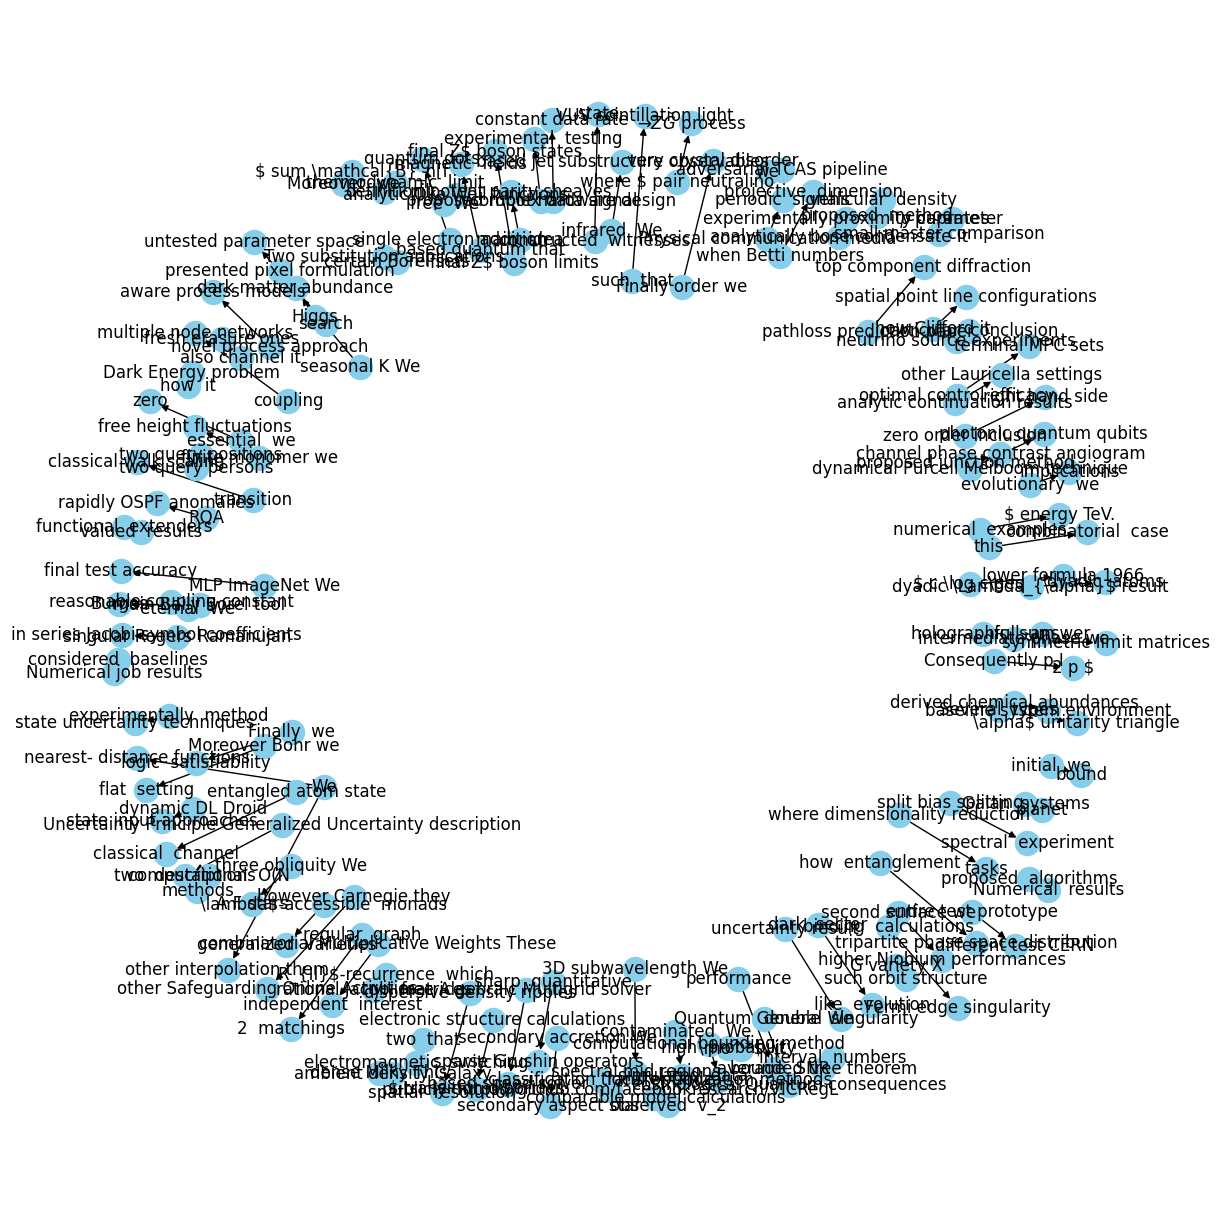

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

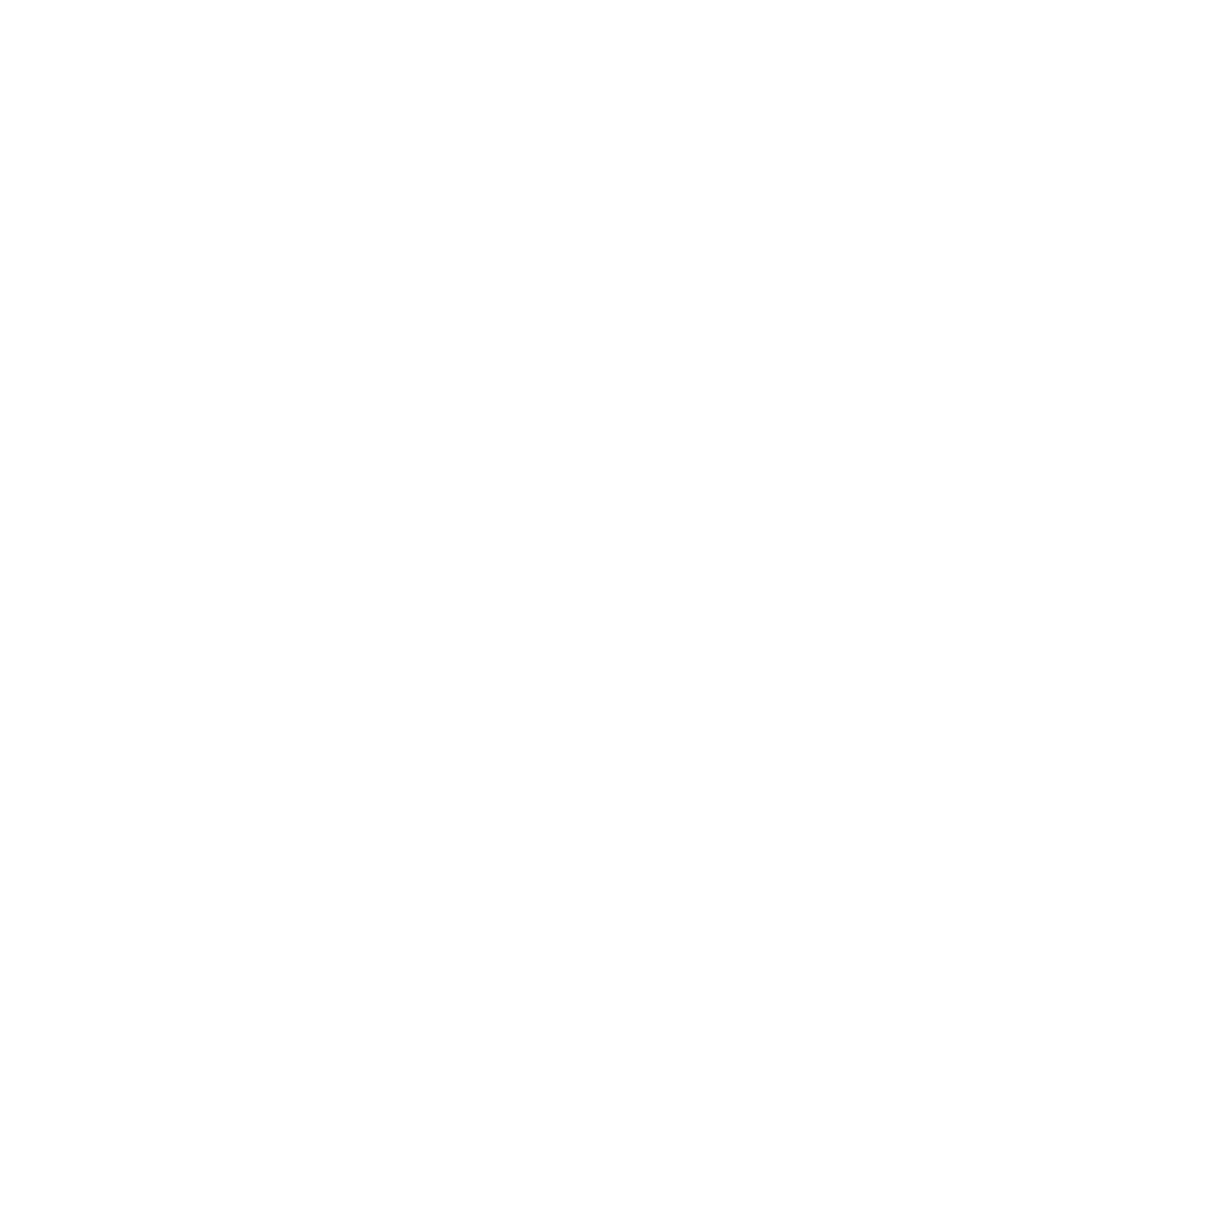

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="used by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### NLP pre-processing

### Regression model 

## Interface - liam